# 03_Modeling

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, adjusted_rand_score, roc_auc_score, average_precision_score, silhouette_score
import hdbscan
import umap
import joblib  
from visualization import compare_hdbscan_params, plot_metrics_comparison
import plotly.express as px

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [5]:
df = pd.read_csv('../data/processed/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]  # Features
y = df['is_attack']  # Labels

## HDBSCAN

### Selecting hyperparameters

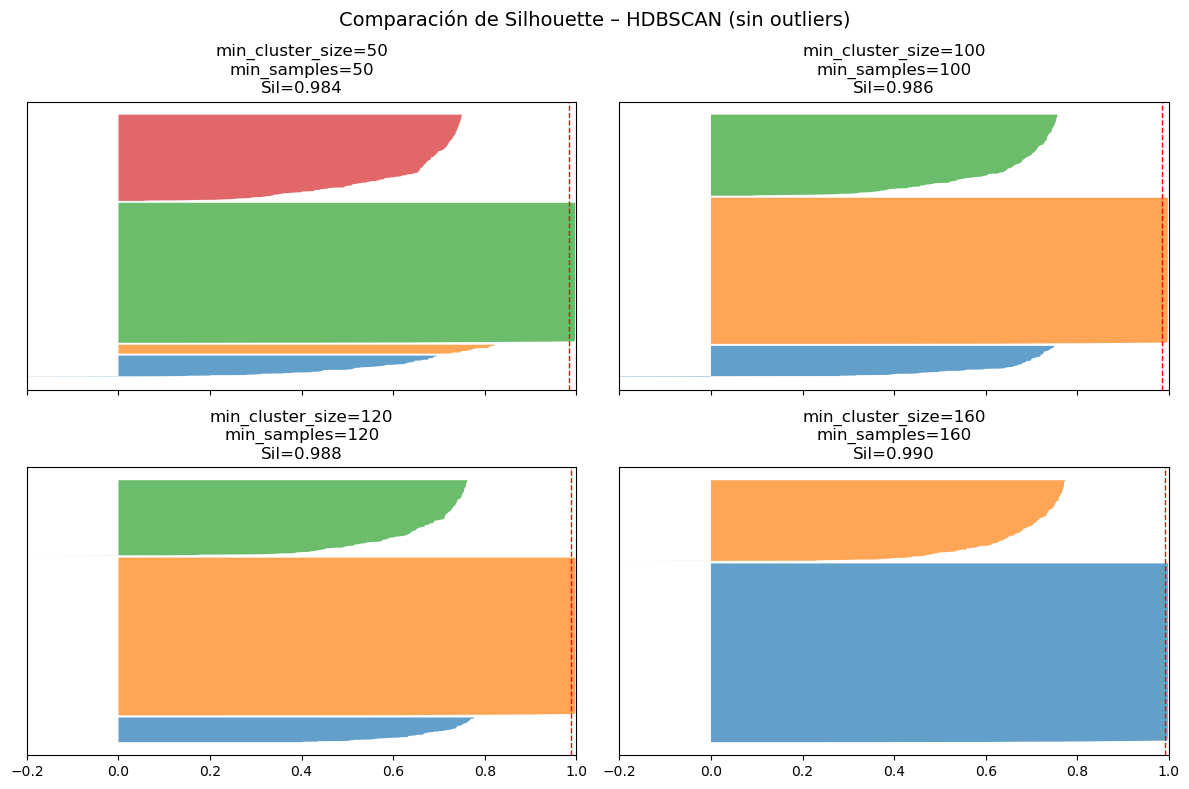

In [6]:
param_grid = [
    (50, 50),
    (100, 100),
    (120, 120),
    (160, 160),
]

# Ejecuta la comparación CON etiquetas verdaderas
results, fig1 = compare_hdbscan_params(
    X, 
    param_grid,
    y_true=y,  # <-- Pasa las etiquetas verdaderas aquí
    n_cols=2
)

plt.show()

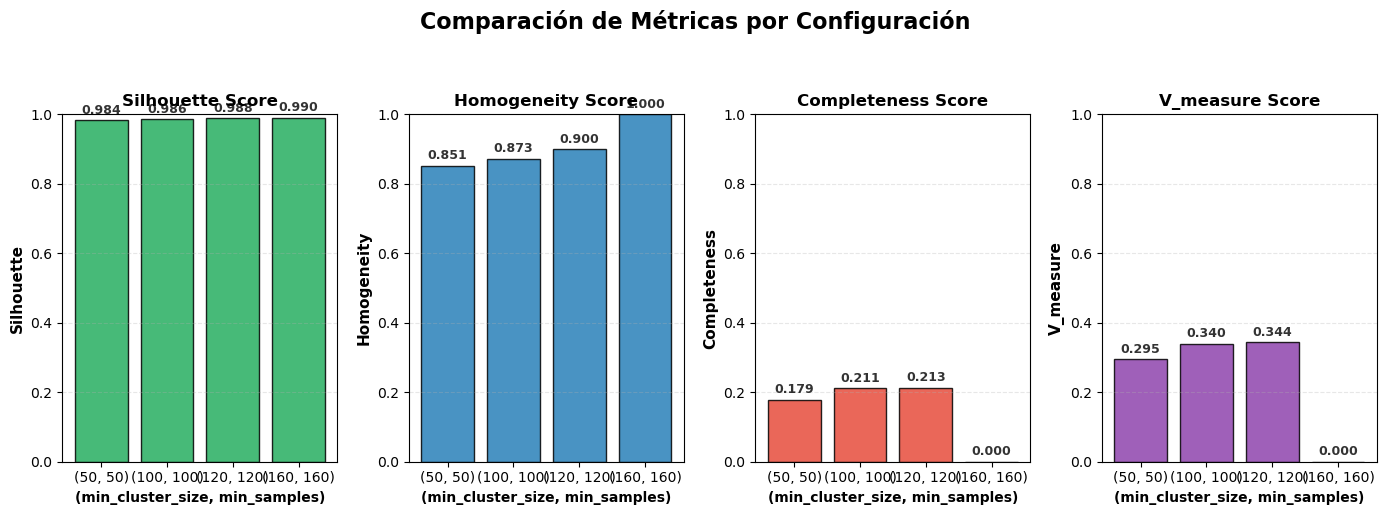

In [7]:
fig2 = plot_metrics_comparison(results)
plt.show()

### Fitting the model

In [8]:
# -----------------------------
# HDBSCAN clustering
# -----------------------------
hdb = hdbscan.HDBSCAN(
    min_cluster_size=120,#Se recomienda igualar min_samples a min_cluster_size para outlier detection
    min_samples=120, # bajarlo significa tomar mas riesgo y clusterizar mas puntos, subirlo significa ser mas conservador y detectar mas outliers
    cluster_selection_method='eom', # 'leaf' or 'eom' EXCESS of Mass para clusters más grandes y estables
    metric='euclidean'
)
hdb_labels = hdb.fit_predict(X)
print("HDBSCAN clusters:", np.unique(hdb_labels))

HDBSCAN clusters: [-1  0  1  2]


In [9]:
# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(X)

df_vis = df.copy()
df_vis['UMAP1'] = X_umap[:, 0]
df_vis['UMAP2'] = X_umap[:, 1]
df_vis['cluster_label'] = hdb_labels

df_vis['Cluster'] = df_vis['cluster_label'].map(
    lambda lbl: 'Outlier' if lbl == -1 else f'Cluster {lbl}'
)

cluster_order = ['Outlier'] + [f'Cluster {i}' for i in sorted(df_vis[df_vis['cluster_label'] != -1]['cluster_label'].unique())]
df_vis['Cluster'] = pd.Categorical(df_vis['Cluster'], categories=cluster_order, ordered=True)

hover_cols = ['is_attack', 'n_connections'] 

fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=hover_cols,  # Ahora sí: columnas del DataFrame
    title="UMAP + HDBSCAN clusters",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='HDBSCAN Clusters')
fig.write_image(
    "../reports/figures/umap_hdbscan_210.png",
    width=1000,      # ancho en píxeles
    height=600,      # alto en píxeles
    scale=2          # factor de escalado (2 = ~200 DPI)
)
fig.show()

/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.16s - Expected: /Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd_attach_to_process/attach.dylib to exist.
/Users/taxi/miniconda3/envs/consoning/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [10]:
pd.crosstab(df['is_attack'], hdb_labels)

col_0,-1,0,1,2
is_attack,,,,
0.0,1195,26,22056,382
1.0,246,100,0,0


## Save model

In [11]:
joblib.dump(hdb, "../models/hdbscan_model.joblib")

['../models/hdbscan_model.joblib']